In [1]:
import os
import subprocess
import struct
import numpy as np
import time
%matplotlib inline
import matplotlib
matplotlib.rcParams['axes.formatter.useoffset'] = False
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
HOST = 'rfsoc1-ctrl-1'
ATA_SNAP = '/home/sonata/jackh/ata_snap'
FPGFILE = '/home/sonata/jackh/ata_rfsoc/zrf_volt_1ant_8bit/outputs/zrf_volt_1ant_8bit_2021-11-12_1432.fpg'
CONFIGFILE = '%s/sw/config/ataconfig_single_sink_8bit_phase.yml' % ATA_SNAP
import logging
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.INFO)

In [41]:
# Initialize RFSoC. Send 1 dual-pol data stream only
os.system('python %s/sw/ata_snap/scripts/rfsoc_feng_init.py %s %s %s  -i 0 -j 0 -s --eth_volt' % (ATA_SNAP, HOST, FPGFILE, CONFIGFILE))

0

In [2]:
from ata_snap import ata_rfsoc_fengine
f = ata_rfsoc_fengine.AtaRfsocFengine('rfsoc1-ctrl-1')
f.fpga.get_system_information(FPGFILE)
f.logger.addHandler(stream_handler)

In [3]:
# Put board in noise test vector mode
f.fpga.write_int('noise_gen1_noise_en', 1); f.fpga.write_int('noise_gen0_noise_en', 1)

In [44]:
def plot_with_delay(f, delay, phase, hack_chans=False):
    """
    Plot cross-power spectrum on top of expected phase.
    f: AtaRfsocFengine instance
    delay: Delay in ADC samples
    """
    x = f.spec_read(mode='cross', flush=True)
    nchan = x.shape[0]
    print("Phase of channel 0: %f" % np.angle(x[0]))
    print("Phase of channel %d: %f" % (nchan-1, np.angle(x[-1])))
    chans = np.linspace(0, 1, nchan, endpoint=False)
    if hack_chans:
        chans[chans>=0.5] -= 1
    expected_phase = chans * np.pi * delay - phase
    expected_data = np.exp(1j*expected_phase)
    plt.subplot(3,1,1)
    #plt.xlabel('Channel Number')
    plt.ylabel('abs(X*Y\')')
    plt.plot(np.abs(x))
    plt.subplot(3,1,2)
    #plt.xlabel('Channel Number')
    plt.ylabel('phase(X*Y\')\n[rads]')
    plt.plot(np.angle(x), 'o', label='data')
    plt.plot(np.angle(expected_data), label='expected')
    plt.legend()
    plt.subplot(3,1,3)
    plt.xlabel('Channel Number')
    plt.ylabel('phase\ndeviation\n[rads]')
    plt.plot(np.angle(x * np.conj(expected_data)))

def sample_to_time(t_sample, clock_rate_hz=2048000000):
    return t_sample / clock_rate_hz * 1e9
    
def set_sample_delay(f, delay, phase):
    f.set_delay_tracking([sample_to_time(delay), 0], [0,0], [phase,0], [0,0], load_time=time.time()+1)
    time.sleep(1.5)
    
def set_and_plot(f, delay_samples, phase=0, hack_chans=False):
    set_sample_delay(f, delay_samples, phase)
    x_slope = f.fpga.read_int('pipeline0_phase_rotate_fd0_slope') / 2**31
    y_slope = f.fpga.read_int('pipeline0_phase_rotate_fd1_slope') / 2**31
    x_phase = f.fpga.read_int('pipeline0_phase_rotate_fd0_phase') / 2**31
    y_phase = f.fpga.read_int('pipeline0_phase_rotate_fd1_phase') / 2**31
    print("Firmware reported x-slope: %f, y-slope: %f" % (x_slope, y_slope))
    print("Firmware reported x-phase: %f, y-phase: %f" % (x_phase, y_phase))
    plot_with_delay(f, delay_samples, phase, hack_chans=hack_chans)


First, let's just try out some delays applied to X-pol, and look at X vs Y correlation

Setting delays to [0.0, 0] ns at time Fri Nov 12 18:29:44 2021
Setting delays to [0.0, 0] ns at time Fri Nov 12 18:29:44 2021
Integer sample delays: [0 0]
Integer sample delays: [0 0]
Fractional sample delays: [0. 0.]
Fractional sample delays: [0. 0.]
Phase being set to: [0. 0.]
Phase being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Firmware reports delays will be loaded at spectra 8023068
Firmware reports delays will be loaded at spectra 8023068


Firmware reported x-slope: 0.000000, y-slope: 0.000000
Firmware reported x-phase: 0.000000, y-phase: 0.000000
Phase of channel 0: 0.000000
Phase of channel 2047: 0.000000


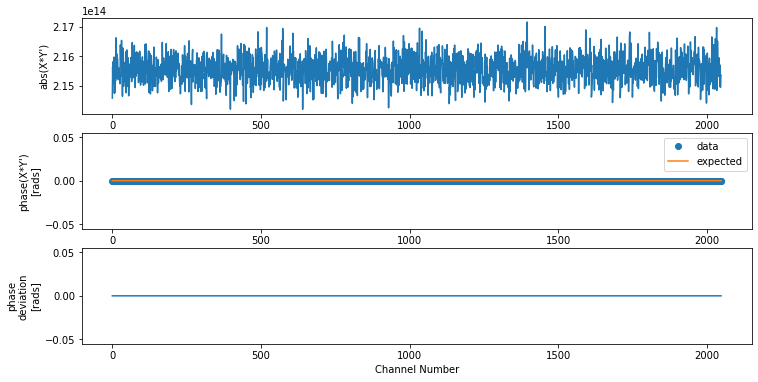

In [45]:
set_and_plot(f, 0)

Setting delays to [0.48828125, 0] ns at time Fri Nov 12 18:29:50 2021
Setting delays to [0.48828125, 0] ns at time Fri Nov 12 18:29:50 2021
Integer sample delays: [1 0]
Integer sample delays: [1 0]
Fractional sample delays: [2.22044605e-16 0.00000000e+00]
Fractional sample delays: [2.22044605e-16 0.00000000e+00]
Phase being set to: [0. 0.]
Phase being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Firmware reports delays will be loaded at spectra 11022540
Firmware reports delays will be loaded at spectra 11022540


Firmware reported x-slope: 0.000000, y-slope: 0.000000
Firmware reported x-phase: 0.000000, y-phase: 0.000000
Phase of channel 0: 0.000000
Phase of channel 2047: 3.140059


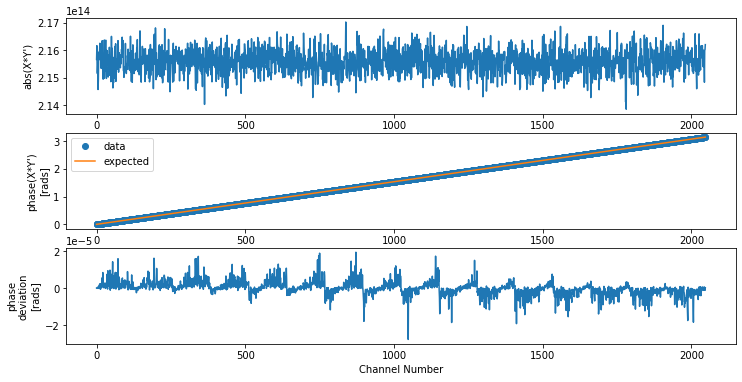

In [46]:
set_and_plot(f, 1)

Setting delays to [4.8828125, 0] ns at time Fri Nov 12 18:29:57 2021
Setting delays to [4.8828125, 0] ns at time Fri Nov 12 18:29:57 2021
Integer sample delays: [10  0]
Integer sample delays: [10  0]
Fractional sample delays: [1.77635684e-15 0.00000000e+00]
Fractional sample delays: [1.77635684e-15 0.00000000e+00]
Phase being set to: [0. 0.]
Phase being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Firmware reports delays will be loaded at spectra 14960284
Firmware reports delays will be loaded at spectra 14960284


Firmware reported x-slope: 0.000000, y-slope: 0.000000
Firmware reported x-phase: 0.000000, y-phase: 0.000000
Phase of channel 0: 0.000000
Phase of channel 2047: -0.015340


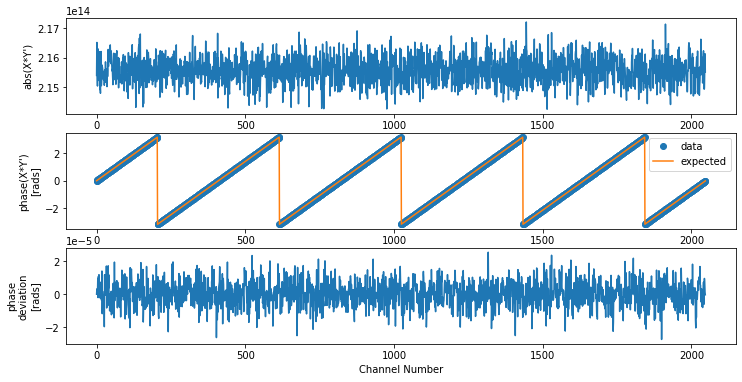

In [47]:
set_and_plot(f, 10)

Setting delays to [48.828125, 0] ns at time Fri Nov 12 18:30:05 2021
Setting delays to [48.828125, 0] ns at time Fri Nov 12 18:30:05 2021
Integer sample delays: [100   0]
Integer sample delays: [100   0]
Fractional sample delays: [1.42108547e-14 0.00000000e+00]
Fractional sample delays: [1.42108547e-14 0.00000000e+00]
Phase being set to: [0. 0.]
Phase being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Firmware reports delays will be loaded at spectra 18587900
Firmware reports delays will be loaded at spectra 18587900


Firmware reported x-slope: 0.000000, y-slope: 0.000000
Firmware reported x-phase: 0.000000, y-phase: 0.000000
Phase of channel 0: 0.000000
Phase of channel 2047: -0.153297


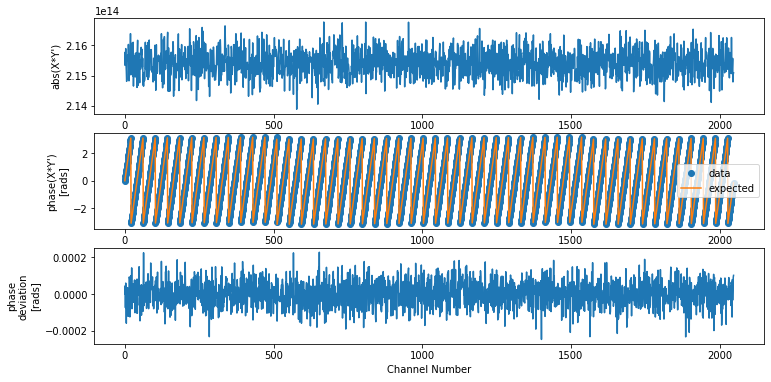

In [48]:
set_and_plot(f, 100)

Setting delays to [0.06103515625, 0] ns at time Fri Nov 12 18:30:27 2021
Setting delays to [0.06103515625, 0] ns at time Fri Nov 12 18:30:27 2021
Integer sample delays: [0 0]
Integer sample delays: [0 0]
Fractional sample delays: [0.125 0.   ]
Fractional sample delays: [0.125 0.   ]
Phase being set to: [0. 0.]
Phase being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Firmware reports delays will be loaded at spectra 29735716
Firmware reports delays will be loaded at spectra 29735716


Firmware reported x-slope: -0.125000, y-slope: 0.000000
Firmware reported x-phase: 0.000000, y-phase: 0.000000
Phase of channel 0: 0.000000
Phase of channel 2047: 0.392698


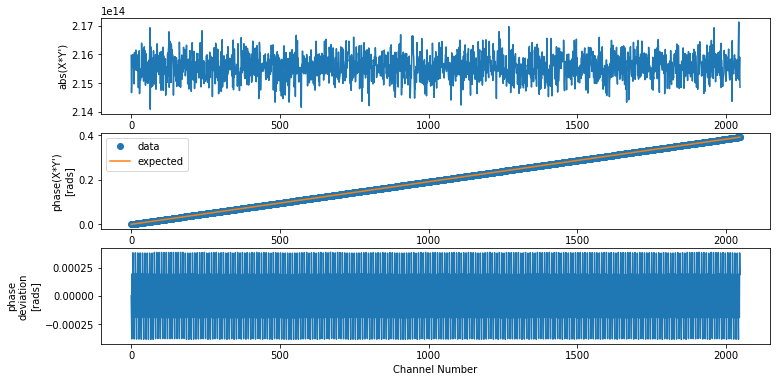

In [51]:
set_and_plot(f, 0.125)

Setting delays to [2.50244140625, 0] ns at time Fri Nov 12 18:30:38 2021
Setting delays to [2.50244140625, 0] ns at time Fri Nov 12 18:30:38 2021
Integer sample delays: [5 0]
Integer sample delays: [5 0]
Fractional sample delays: [0.125 0.   ]
Fractional sample delays: [0.125 0.   ]
Phase being set to: [0. 0.]
Phase being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Firmware reports delays will be loaded at spectra 35484884
Firmware reports delays will be loaded at spectra 35484884


Firmware reported x-slope: -0.125000, y-slope: 0.000000
Firmware reported x-phase: 0.000000, y-phase: 0.000000
Phase of channel 0: 0.000000
Phase of channel 2047: -2.756566


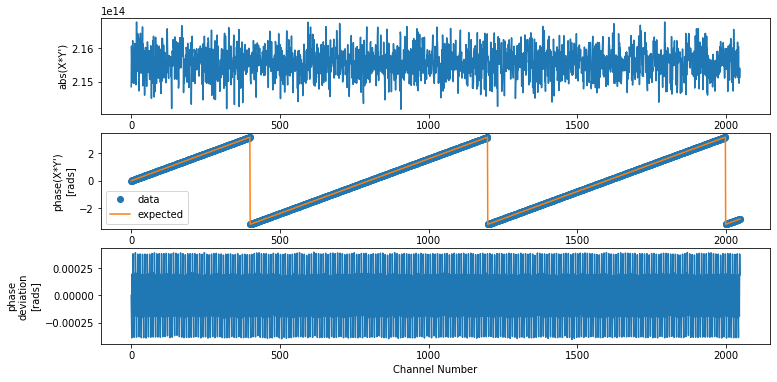

In [52]:
set_and_plot(f, 5.125)

Now try similar tests with phase:

Setting delays to [0.0, 0] ns at time Fri Nov 12 18:31:00 2021
Setting delays to [0.0, 0] ns at time Fri Nov 12 18:31:00 2021
Integer sample delays: [0 0]
Integer sample delays: [0 0]
Fractional sample delays: [0. 0.]
Fractional sample delays: [0. 0.]
Phase being set to: [0.31830989 0.        ]
Phase being set to: [0.31830989 0.        ]
Phase rates being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Firmware reports delays will be loaded at spectra 46285536
Firmware reports delays will be loaded at spectra 46285536


Firmware reported x-slope: 0.000000, y-slope: 0.000000
Firmware reported x-phase: 0.318310, y-phase: 0.000000
Phase of channel 0: -1.000157
Phase of channel 2047: -1.000157


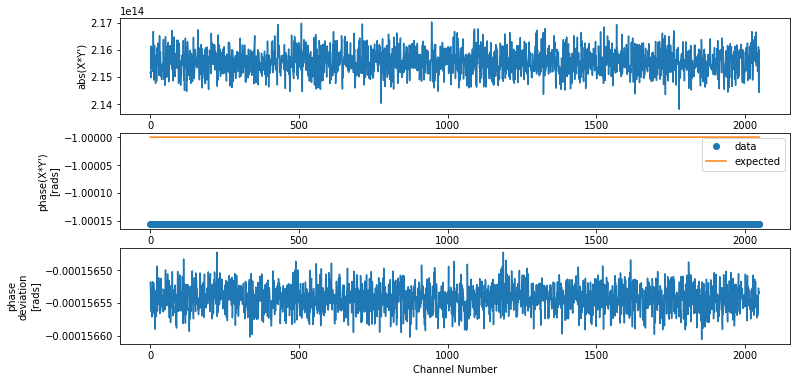

In [53]:
set_and_plot(f, 0, phase=1.0)

Setting delays to [0.0, 0] ns at time Fri Nov 12 18:31:05 2021
Setting delays to [0.0, 0] ns at time Fri Nov 12 18:31:05 2021
Integer sample delays: [0 0]
Integer sample delays: [0 0]
Fractional sample delays: [0. 0.]
Fractional sample delays: [0. 0.]
Phase being set to: [-1.  0.]
Phase being set to: [-1.  0.]
Phase rates being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Firmware reports delays will be loaded at spectra 48978980
Firmware reports delays will be loaded at spectra 48978980


Firmware reported x-slope: 0.000000, y-slope: 0.000000
Firmware reported x-phase: -1.000000, y-phase: 0.000000
Phase of channel 0: 3.141593
Phase of channel 2047: 3.141593


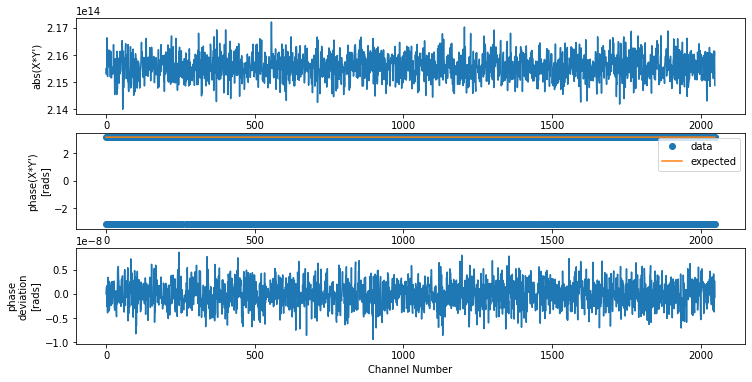

In [54]:
set_and_plot(f, 0, phase=-np.pi)

Setting delays to [0.0, 0] ns at time Fri Nov 12 18:31:11 2021
Setting delays to [0.0, 0] ns at time Fri Nov 12 18:31:11 2021
Integer sample delays: [0 0]
Integer sample delays: [0 0]
Fractional sample delays: [0. 0.]
Fractional sample delays: [0. 0.]
Phase being set to: [0.5 0. ]
Phase being set to: [0.5 0. ]
Phase rates being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Firmware reports delays will be loaded at spectra 51906944
Firmware reports delays will be loaded at spectra 51906944


Firmware reported x-slope: 0.000000, y-slope: 0.000000
Firmware reported x-phase: 0.500000, y-phase: 0.000000
Phase of channel 0: -1.570796
Phase of channel 2047: -1.570796


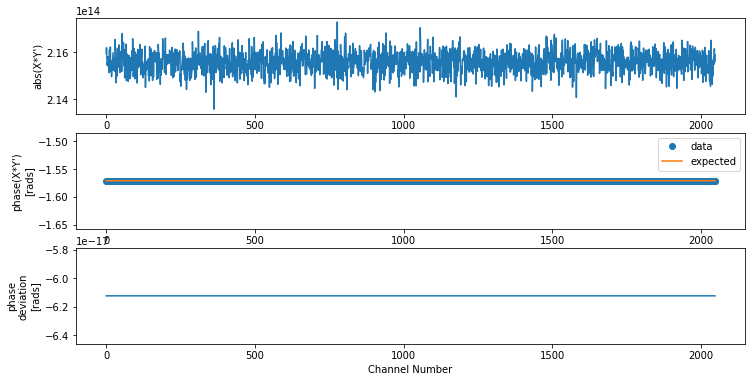

In [55]:
set_and_plot(f, 0, phase=0.5*np.pi)

Setting delays to [0.0, 0] ns at time Fri Nov 12 18:31:18 2021
Setting delays to [0.0, 0] ns at time Fri Nov 12 18:31:18 2021
Integer sample delays: [0 0]
Integer sample delays: [0 0]
Fractional sample delays: [0. 0.]
Fractional sample delays: [0. 0.]
Phase being set to: [0.001 0.   ]
Phase being set to: [0.001 0.   ]
Phase rates being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Firmware reports delays will be loaded at spectra 55323236
Firmware reports delays will be loaded at spectra 55323236


Firmware reported x-slope: 0.000000, y-slope: 0.000000
Firmware reported x-phase: 0.001000, y-phase: 0.000000
Phase of channel 0: -0.003067
Phase of channel 2047: -0.003067


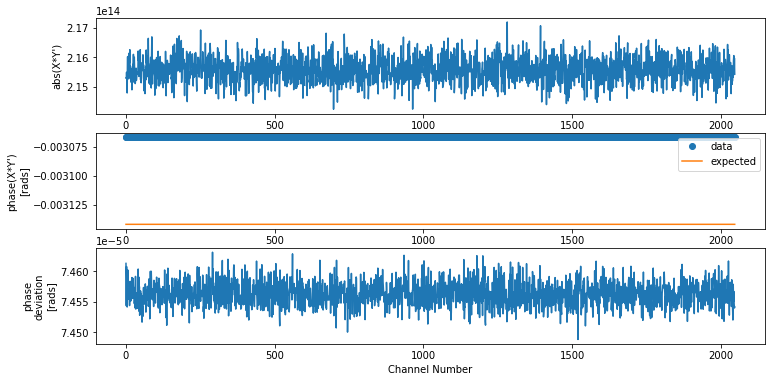

In [56]:
set_and_plot(f, 0, phase=0.001*np.pi)

Setting delays to [2.99072265625, 0] ns at time Fri Nov 12 18:31:41 2021
Setting delays to [2.99072265625, 0] ns at time Fri Nov 12 18:31:41 2021
Integer sample delays: [6 0]
Integer sample delays: [6 0]
Fractional sample delays: [0.125 0.   ]
Fractional sample delays: [0.125 0.   ]
Phase being set to: [0.03183099 0.        ]
Phase being set to: [0.03183099 0.        ]
Phase rates being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Firmware reports delays will be loaded at spectra 66974984
Firmware reports delays will be loaded at spectra 66974984


Firmware reported x-slope: -0.125000, y-slope: 0.000000
Firmware reported x-phase: 0.031831, y-phase: 0.000000
Phase of channel 0: -0.099706
Phase of channel 2047: 0.283015


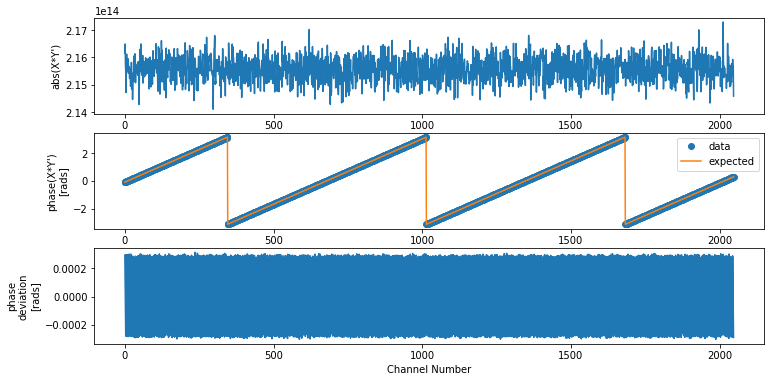

In [59]:
set_and_plot(f, 6.125, phase=0.1)

# Timing Tests

Here we grab packets, and see when phase changes occur

In [4]:
def decode_packet(pkt):
    HEADER_BYTES = 16
    NCHAN = 32
    NTIME = 16
    header = struct.unpack(">BBHHHQ", pkt[0:HEADER_BYTES])
    d = np.frombuffer(pkt[HEADER_BYTES:], dtype=">b")
    h = {}
    h['timestamp'] = header[5]
    h['feng_id'] = header[4]
    h['chan']    = header[3]
    h['n_chans'] = header[2]
    h['type']    = header[1]
    h['version'] = header[0]
    #h['feng_id'] = header[0] & 0xffff
    #h['chan']    = (header[0] >> 16) & 0xffff
    #h['n_chans'] = (header[0] >> 32) & 0xffff
    #h['type']    = (header[0] >> 48) & 0xff
    #h['version'] = (header[0] >> 56) & 0xff
    xr = d[0::4]
    xi = d[1::4]
    yr = d[2::4]
    yi = d[3::4]
    x = (xr + 1j*xi).reshape(NCHAN, NTIME)
    y = (yr + 1j*yi).reshape(NCHAN, NTIME)
    return h, x, y


def examine_packets(fname, target_mcnt):
    NCHAN = 32
    NTIME = 16
    NPOL = 2
    NBYTE = 2
    HEADER_BYTES = 16
    WINDOW_SIZE = 1000
    t = []
    p = []
    fh = open(fname, 'rb')
    packet_size = NCHAN * NTIME * NPOL * NBYTE + HEADER_BYTES
    print("Opening file %s" % fname)
    print("Packet size is %d bytes" % packet_size)
    pn = 0

    d = fh.read(packet_size)
    h, x, y = decode_packet(d)
    print("First packet timestamp is %d" % h['timestamp'])
    t_offset = target_mcnt - h['timestamp']
    if t_offset < 0:
        print("Target timestamp (%d) not in file!" % target_mcnt)
        fh.close()
        return
    p_offset = t_offset // NTIME
    print("Packet offset is %d" % p_offset)
    if p_offset < WINDOW_SIZE:
        p_offset = 0
    else:
        p_offset = p_offset - WINDOW_SIZE
    fh.seek(p_offset * packet_size)
    # HACK
    # Sometimes packets at the beginning of a capture are missing. Go backwards if necessary
    d = fh.read(packet_size)
    h, x, y = decode_packet(d)
    if h['timestamp'] > target_mcnt:
        p_offset = p_offset - ((h['timestamp'] - target_mcnt) // NTIME) - WINDOW_SIZE
        fh.seek(p_offset * packet_size)
    while(True):
        d = fh.read(packet_size)
        if len(d) < packet_size:
            break
        if pn > 2*WINDOW_SIZE:
            break
        h, x, y = decode_packet(d)
        for i in range(NTIME):
            t += [h['timestamp'] + i]
            p += [np.angle(x[:,i] * np.conj(y[:,i]))]
        pn += 1    
    p = np.array(p)
    t = np.array(t)
    #for chan in range(0,10):
    nchans = p.shape[1]
    t_origin = target_mcnt
    for c in range(4):
        plt.plot(t - t_origin, p[:,c], '-o', label='Channel %d' % c)
    plt.plot(t - t_origin, p[:,nchans-1], '-o', label='Channel %d' % (nchans-1))
    plt.xlim((-10, 10))
    plt.xlabel('Timestamp - %d' % t_origin)
    plt.ylabel('Phase')
    plt.legend()
    fh.close()
    plt.show()

In [5]:
def capture_data_at_delay(delay, delay_rate=0, phase=0, phase_rate=0):
    """Delay in ns!!!"""
    #Record 20 seconds of data
    IP = '10.11.1.51' # should match config file
    PORT = 10000      # should match config file
    TWAIT = 10
    FNAME = '/mnt/buf0/temp.packets'
    #Set delays to load 5 seconds in the future and record 10 seconds of data
    print('Resetting delays')
    f.set_delay_tracking([0,0], [0,0], [0,0], [0,0], load_time=time.time() + 1) # reset delays
    f.fpga.write_int('noise_gen1_noise_en', 1); f.fpga.write_int('noise_gen0_noise_en', 1) # re-enable noise
    f.eq_load_coeffs(0,300); f.eq_load_coeffs(1,300) # Vaguely appropriate for noise source
    time.sleep(3)
    print('Queueing new delays')
    t = f.set_delay_tracking([delay,0], [delay_rate,0], [phase,0], [phase_rate,0], load_time=time.time() + TWAIT) # DELAYS in ns!!!
    print('Delays will load at timestamp %d' % t)
    print('Capturing packets')
    os.system('python %s/sw/ata_snap/scripts/snap_feng_rx.py -i %s -p %d -f %s -t %d' % (ATA_SNAP, IP, PORT, FNAME, TWAIT+2))
    return FNAME, t

Setting delays to [0, 0] ns at time Fri Nov 12 18:32:02 2021
Setting delays to [0, 0] ns at time Fri Nov 12 18:32:02 2021
Integer sample delays: [0 0]
Integer sample delays: [0 0]
Fractional sample delays: [0. 0.]
Fractional sample delays: [0. 0.]
Phase being set to: [0. 0.]
Phase being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Firmware reports delays will be loaded at spectra 77077272
Firmware reports delays will be loaded at spectra 77077272


Resetting delays


Setting delays to [0.3, 0] ns at time Fri Nov 12 18:32:14 2021
Setting delays to [0.3, 0] ns at time Fri Nov 12 18:32:14 2021
Integer sample delays: [0 0]
Integer sample delays: [0 0]
Fractional sample delays: [0.6144 0.    ]
Fractional sample delays: [0.6144 0.    ]
Phase being set to: [0. 0.]
Phase being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Firmware reports delays will be loaded at spectra 83094748
Firmware reports delays will be loaded at spectra 83094748


Queueing new delays
Delays will load at timestamp 83094748
Capturing packets
Opening file /mnt/buf0/temp.packets
Packet size is 2064 bytes
First packet timestamp is 78196688
Packet offset is 306128


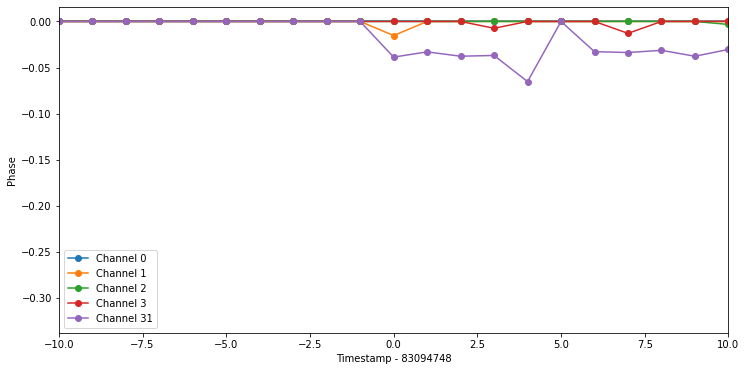

In [62]:
# Examine the relative phase of X and Y in the packet stream
# Look at the samples around to spectra ID when the delays were loaded.
# The target spectra ID should be the first sample with non-zero phase difference between X and Y pol.
fname, t = capture_data_at_delay(0.3) # 0.3ns < 1 sample --> Delay is applied only after the FFT
examine_packets(fname, t)

So:
 * Coarse and Fine delay values are OK
 * Loaded Phase values are OK
 * Fine delays are correctly loading on the commanded timestamp

Setting delays to [0, 0] ns at time Fri Nov 12 18:32:32 2021
Setting delays to [0, 0] ns at time Fri Nov 12 18:32:32 2021
Integer sample delays: [0 0]
Integer sample delays: [0 0]
Fractional sample delays: [0. 0.]
Fractional sample delays: [0. 0.]
Phase being set to: [0. 0.]
Phase being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Firmware reports delays will be loaded at spectra 92395804
Firmware reports delays will be loaded at spectra 92395804


Resetting delays


Setting delays to [14.6484375, 0] ns at time Fri Nov 12 18:32:44 2021
Setting delays to [14.6484375, 0] ns at time Fri Nov 12 18:32:44 2021
Integer sample delays: [30  0]
Integer sample delays: [30  0]
Fractional sample delays: [3.55271368e-15 0.00000000e+00]
Fractional sample delays: [3.55271368e-15 0.00000000e+00]
Phase being set to: [0. 0.]
Phase being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Firmware reports delays will be loaded at spectra 98413424
Firmware reports delays will be loaded at spectra 98413424


Queueing new delays
Delays will load at timestamp 98413424
Capturing packets
Opening file /mnt/buf0/temp.packets
Packet size is 2064 bytes
First packet timestamp is 93496032
Packet offset is 307337


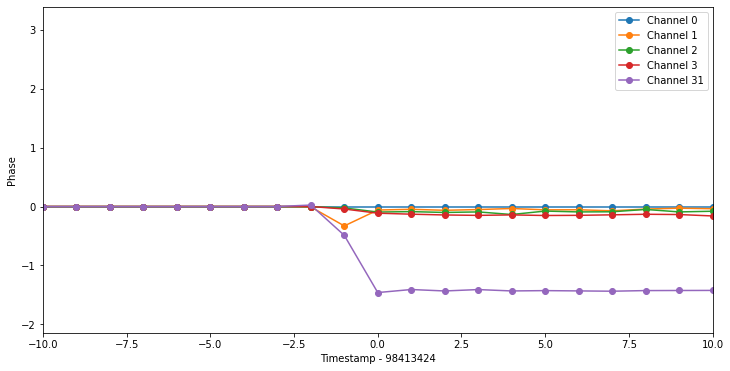

In [63]:
# Examine the relative phase of X and Y in the packet stream
# Look at the samples around to spectra ID when the delays were loaded.
# The target spectra ID should be the first sample with non-zero phase difference between X and Y pol.
fname, t = capture_data_at_delay(30./2048e6 * 1e9) # 30 samples --> Delay is applied only before the FFT
examine_packets(fname, t)

I *think* the above is right. The 4-tap PFB indexes spectra such that spectra `N` has contributions from spectra `N`, `N-1`, `N-2`, and `N-3`. So, phase variation is expected from the spectra with timestamp `DELAY_CHANGE_TARGET-3`. DC bin can be `pi` out of phase if it changes sign.


# Update Rates

Now, let's look at the update rates

Phase rates [radians per sec]: [0, 0]
Phase rates [radians per spectrum]: [0. 0.]
Phase rates [pis per spectrum]: [0. 0.]
Wrapped Phase rates [pis per spectrum]: [0. 0.]
Setting delays to [0, 0] ns at time Fri Nov 12 18:50:01 2021
Integer sample delays: [0 0]
Fractional sample delays: [0. 0.]
Phase being set to: [0. 0.]
Phase rates being set to: [0. 0.]
Firmware reports delays will be loaded at spectra 616788244


Resetting delays


Phase rates [radians per sec]: [20000, 0]
Phase rates [radians per spectrum]: [0.04 0.  ]
Phase rates [pis per spectrum]: [0.0127324 0.       ]
Wrapped Phase rates [pis per spectrum]: [0.0127324 0.       ]
Setting delays to [0, 0] ns at time Fri Nov 12 18:50:13 2021
Integer sample delays: [0 0]
Fractional sample delays: [0. 0.]
Phase being set to: [0. 0.]
Phase rates being set to: [0.0127324 0.       ]
Firmware reports delays will be loaded at spectra 622806348


Queueing new delays
Delays will load at timestamp 622806348
Capturing packets
Opening file /mnt/buf0/temp.packets
Packet size is 2064 bytes
First packet timestamp is 617885472
Packet offset is 307554


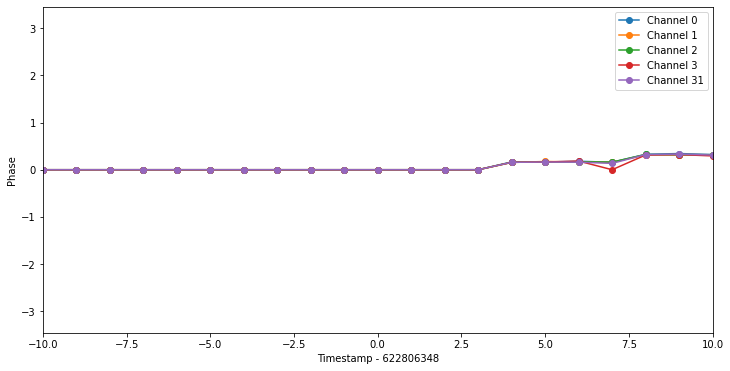

In [14]:
# Examine the relative phase of X and Y in the packet stream when applying zero delay but not-zero increment rate.

fname, t = capture_data_at_delay(0, phase=0, phase_rate=20000)
examine_packets(fname, t)

In [65]:
def plot_reported_phase(f, duration=30):
    t = []
    p = []
    s = []
    starttime = time.time()
    while(True):
        t += [time.time()]
        p += [f.fpga.read_int('pipeline0_phase_rotate_fd0_phase')]
        s += [f.fpga.read_int('pipeline0_phase_rotate_fd0_slope')]
        if t[-1] > starttime + duration:
            break
    t = np.array(t)
    p = np.array(p) * np.pi / 2**31
    pu = np.unwrap(p)
    s = np.array(s) * np.pi / 2**31
    su = np.unwrap(s)
    dp = p[-1] - p[0]
    ds = s[-1] - s[0]
    dt = t[-1] - t[0]
    print("Phase dp/dt: %f Radians per second" % (dp/dt))
    print("Slope ds/dt: %f ADC samples per second" % (ds/dt / np.pi))
    plt.subplot(2,1,1)
    plt.plot(t-t[0], p)
    plt.ylabel('Phase')
    plt.subplot(2,1,2)
    plt.plot(t-t[0],s)
    plt.ylabel('slope')
    plt.xlabel('Time [s]')
    plt.show()

Setting delays to [0, 0] ns at time Fri Nov 12 18:34:43 2021
Setting delays to [0, 0] ns at time Fri Nov 12 18:34:43 2021
Integer sample delays: [0 0]
Integer sample delays: [0 0]
Fractional sample delays: [0. 0.]
Fractional sample delays: [0. 0.]
Phase being set to: [0. 0.]
Phase being set to: [0. 0.]
Phase rates being set to: [3.18309886e-08 0.00000000e+00]
Phase rates being set to: [3.18309886e-08 0.00000000e+00]
Firmware reports delays will be loaded at spectra 157842892
Firmware reports delays will be loaded at spectra 157842892


Phase dp/dt: 0.049991 Radians per second
Slope ds/dt: -0.009997 ADC samples per second


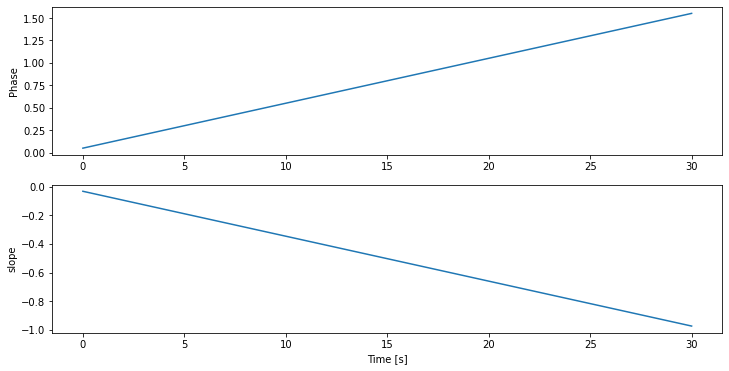

In [66]:
# phase rate 0.05 radians per second
# delay rate: 0.01 sample per second
t = f.set_delay_tracking([0,0], [0.01/2048e6 * 1e9,0], [0,0], [0.05,0], load_time=time.time() + 1)
time.sleep(2)
plot_reported_phase(f, 30)